In [1]:
!mkdir -p results

# Imports

#### General

In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm
from livelossplot import PlotLossesKeras

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### NumPy & randomness

In [3]:
random_state = 1
import numpy as np
np.random.seed(random_state)
import random
random.seed(random_state)

#### Sci-Kit Learn

In [4]:
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

# Data

In [5]:
train = pd.read_csv('../feature_engineering/train.gz')
X_train = train[train.columns[:-1]].values
y_train = train[train.columns[-1]].values

In [6]:
test = pd.read_csv('../feature_engineering/test.gz')
X_test = test[test.columns[:-1]].values
y_test = test[test.columns[-1]].values

# Models

In [7]:
rf = RandomForestRegressor(
    bootstrap=False, 
    criterion='mse', 
    max_depth=None,
    max_features='sqrt', 
    max_leaf_nodes=None,
    min_impurity_decrease=0.001, 
    min_impurity_split=None,
    min_samples_leaf=8, 
    min_samples_split=8,
    min_weight_fraction_leaf=0.0, 
    n_estimators=17, 
    n_jobs=1,
    oob_score=False, 
    random_state=random_state, 
    verbose=0, 
    warm_start=False
)
rf

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=17, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [8]:
br = BayesianRidge(
    alpha_1=1, 
    alpha_2=1, 
    compute_score=False, 
    copy_X=True,
    fit_intercept=True, 
    lambda_1=1, 
    lambda_2=1.0, 
    n_iter=1,
    normalize=False, 
    tol=0.001, 
    verbose=False
)
br

BayesianRidge(alpha_1=1, alpha_2=1, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1, lambda_2=1.0, n_iter=1,
       normalize=False, tol=0.001, verbose=False)

In [9]:
gb = GradientBoostingRegressor(
    alpha=0.9, 
    criterion='friedman_mse', 
    init=None,
    learning_rate=0.3, 
    loss='ls', 
    max_depth=10, 
    max_features=None,
    max_leaf_nodes=100, 
    min_impurity_decrease=0.2,
    min_impurity_split=None, 
    min_samples_leaf=9,
    min_samples_split=3, 
    min_weight_fraction_leaf=0.0,
    n_estimators=21, 
    presort='auto', 
    random_state=random_state,
    subsample=1.0, 
    verbose=0, 
    warm_start=False
)
gb

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=100, min_impurity_decrease=0.2,
             min_impurity_split=None, min_samples_leaf=9,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=21, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=False)

In [10]:
models = {
    rf.__class__.__name__: rf, 
    br.__class__.__name__: br, 
    gb.__class__.__name__: gb
}

#### Fit

In [11]:
for _, model in models.items():
    model.fit(X_train, y_train)

#### Predict

In [12]:
predictions = {name: model.predict(X_train) for (name, model) in models.items()}

In [13]:
train_df = pd.DataFrame(predictions)
train_df['Truth'] = y_train

In [14]:
train_df.head()

,BayesianRidge,GradientBoostingRegressor,RandomForestRegressor,Truth
0,9.769505,13.392991,14.763702,15.55904
1,9.102280,12.998163,13.856789,14.43644
2,7.467854,10.487035,12.983188,13.24040
3,7.063342,10.487035,13.138361,13.49220
4,7.807087,10.463812,13.663825,12.67385


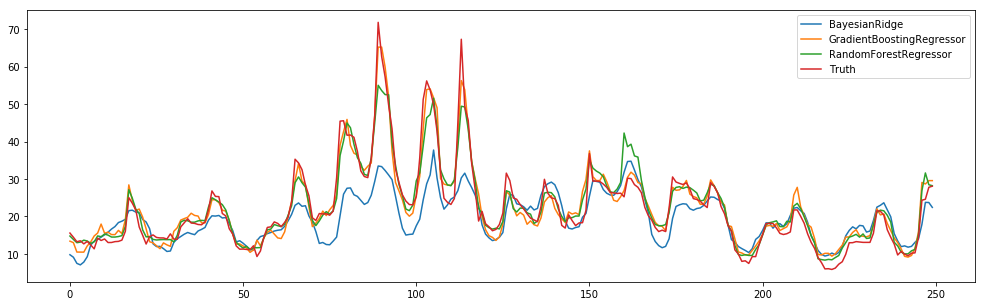

In [15]:
_ = train_df[:250].plot(figsize=(17, 5))

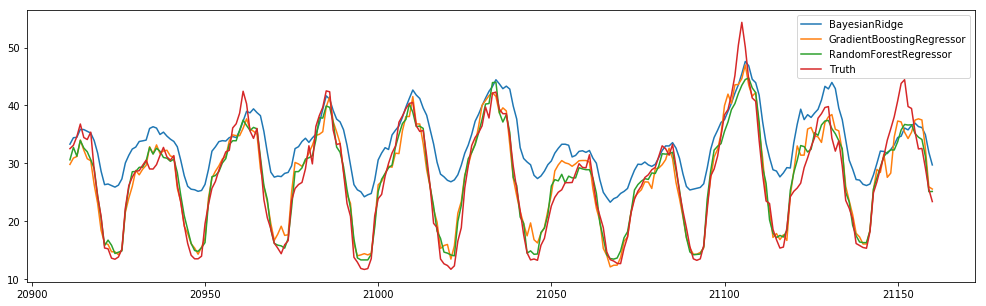

In [16]:
_ = train_df[-250:].plot(figsize=(17, 5))

#### Generate Error

In [17]:
error_df = (train_df.T - y_train.T).T
error_df.head()

,BayesianRidge,GradientBoostingRegressor,RandomForestRegressor,Truth
0,-5.789535,-2.166049,-0.795338,0.0
1,-5.334160,-1.438277,-0.579651,0.0
2,-5.772546,-2.753365,-0.257212,0.0
3,-6.428858,-3.005165,-0.353839,0.0
4,-4.866763,-2.210038,0.989975,0.0


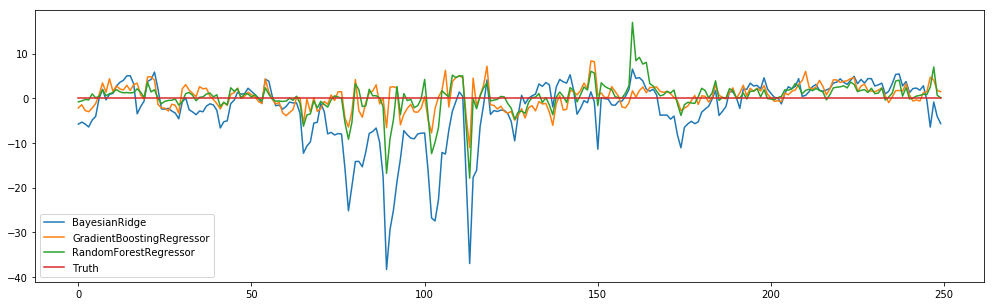

In [18]:
_ = error_df[:250].plot(figsize=(17, 5))

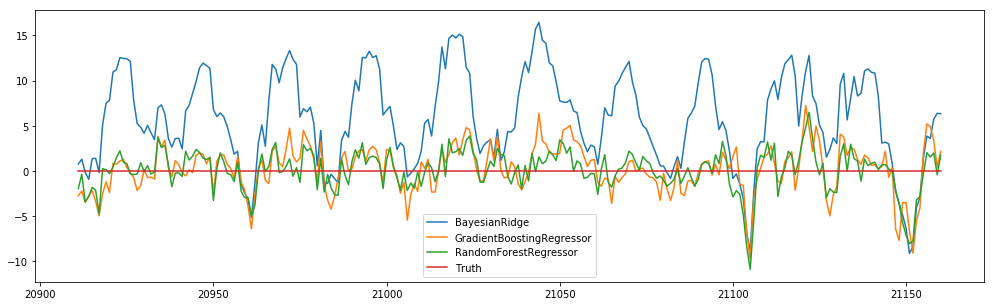

In [19]:
_ = error_df[-250:].plot(figsize=(17, 5))

In [20]:
model_selector = error_df.copy()
del model_selector['Truth']

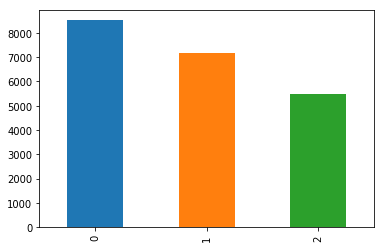

In [21]:
# calculate the column index of the model with the lowest error
min_errors = np.argmin(model_selector.values, axis=1)
_ = pd.Series(min_errors).value_counts().plot(kind='bar')

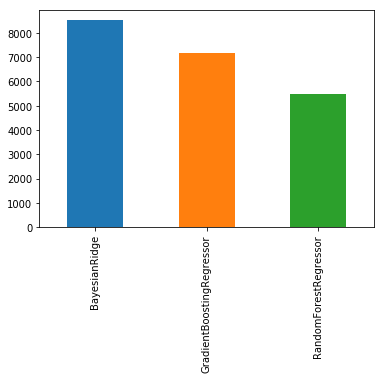

In [22]:
# zero out all the values
model_selector[:] = 0
# fancy index the values that should receive a label of 1
model_selector.values[range(len(model_selector)), min_errors] = 1
# plot the data to ensure the distribution is same as min_errors
_ = model_selector.sum().plot(kind='bar')

In [23]:
model_selector.shape[1]

3

In [24]:
clf = RandomForestClassifier(random_state=1)
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

## Grid Search

In [25]:
cv = KFold(n_splits=3, shuffle=True, random_state=1)
cv

KFold(n_splits=3, random_state=1, shuffle=True)

In [26]:
params = {
    "n_estimators": [1 + 2*x for x in range(1, 12)],
    "max_features": ["sqrt", "log2", None],
    "max_depth": [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_leaf": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "max_leaf_nodes": [2, 5, 10, 50, 100, None],
    "min_impurity_decrease": [0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4],
    "bootstrap": [True, False],
}

In [27]:
grid = EvolutionaryAlgorithmSearchCV(
    estimator=clf, 
    params=params, 
    cv=cv, 
    scoring='accuracy',
    n_jobs=4, 
    population_size=10,
    gene_mutation_prob=0.10,
    gene_crossover_prob=0.5,
    tournament_size=3,
    generations_number=15,
    verbose=1,
)
grid

EvolutionaryAlgorithmSearchCV(cv=KFold(n_splits=3, random_state=1, shuffle=True),
               error_score='raise',
               estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
               fit_params={}, gene_crossover_prob=0.5,
               gene_mutation_prob=0.1, gene_type=None,
               generations_number=15, iid=True, n_jobs=4,
               params={'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_features': ['sqrt', 'log2', None], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'n_estimators': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23], 'bootstrap': [True, False], 'min_impurity_decrease': [0, 0.0

In [28]:
_ = grid.fit(X_train, model_selector.values)

Types [1, 1, 1, 1, 1, 1, 1, 1] and maxint [8, 2, 8, 10, 1, 6, 11, 5] detected
--- Evolve in 2694384 possible combinations ---
gen	nevals	avg      	min	max   	std    
0  	10    	0.0571618	0  	0.3428	0.11713
1  	5     	0.128023 	0  	0.351779	0.15986
2  	5     	0.255257 	0  	0.351779	0.134859
3  	8     	0.295629 	0  	0.498748	0.130316
4  	7     	0.395449 	0.351779	0.498748	0.0667158
5  	8     	0.452498 	0.3428  	0.498748	0.0679568
6  	5     	0.498327 	0.494542	0.498748	0.00126176
7  	4     	0.498748 	0.498748	0.498748	5.55112e-17
8  	6     	0.448873 	0       	0.498748	0.149624   
9  	6     	0.498748 	0.498748	0.498748	5.55112e-17
10 	4     	0.501843 	0.498748	0.529701	0.00928595 
11 	6     	0.501843 	0.498748	0.529701	0.00928595 
12 	3     	0.522565 	0.498748	0.675015	0.0522626  
13 	5     	0.522565 	0.498748	0.675015	0.0522626  
14 	8     	0.546382 	0.498748	0.675015	0.0657892  
15 	6     	0.61689  	0.529701	0.675015	0.0711893  
Best individual is: {'min_samples_leaf': 2, 'max_features':

In [29]:
best = pd.Series(grid.best_params_)
best.to_csv('results/peoh-rf-params.csv')
best

bootstrap                False
max_depth                  100
max_features              None
max_leaf_nodes            None
min_impurity_decrease        0
min_samples_leaf             2
min_samples_split           10
n_estimators                23
dtype: object

In [30]:
results = grid.cv_results_
df = pd.DataFrame(results)
df.to_csv('results/peoh-rf-grid.csv')
df

,index,max_test_score,mean_test_score,min_test_score,nan_test_score?,param_index,params,std_test_score
0,11,0.228817,0.228817,0.228817,False,0,"{'min_samples_leaf': 2, 'max_features': None, ...",0.0
1,12,0.342800,0.342800,0.342800,False,0,"{'min_samples_leaf': 5, 'max_features': 'log2'...",0.0
2,13,0.342800,0.342800,0.342800,False,0,"{'min_samples_leaf': 2, 'max_features': 'log2'...",0.0
3,14,0.000000,0.000000,0.000000,False,0,"{'min_samples_leaf': 2, 'max_features': None, ...",0.0
4,15,0.342800,0.342800,0.342800,False,0,"{'min_samples_leaf': 4, 'max_features': 'log2'...",0.0
5,16,0.234961,0.234961,0.234961,False,0,"{'min_samples_leaf': 2, 'max_features': None, ...",0.0
6,17,0.234961,0.234961,0.234961,False,0,"{'min_samples_leaf': 2, 'max_features': None, ...",0.0
7,18,0.342800,0.342800,0.342800,False,0,"{'min_samples_leaf': 2, 'max_features': 'log2'...",0.0
8,19,0.342800,0.342800,0.342800,False,0,"{'min_samples_leaf': 2, 'max_features': 'log2'...",0.0
9,20,0.000000,0.000000,0.000000,False,0,"{'min_samples_leaf': 2, 'max_features': None, ...",0.0


# Testing

In [31]:
clf = RandomForestClassifier(**grid.best_params_)
clf

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=23, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
clf.fit(X_train, model_selector.values)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=23, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
def get_predictions(X: np.ndarray) -> np.ndarray:
    """
    Generate ensemble predictions for the given dataset.
    
    Args:
        X: the dataset to get predictions from the model for
        
    Returns:
        a vector of predictions from the ensemble
        
    """
    # create an empty list to store predictions in 
    preds = []

    # iterate over each sample in the dataset
    for Xi in tqdm(X):
        # get the output from the loss network
        clf_out = clf.predict(Xi.reshape(1, len(Xi)))
        # determine the index with the highest probability of low error
        clf_idx = np.argmax(clf_out)
        # unwrap the models key and extract it from the dictionary
        model_key = model_selector.columns[clf_idx]
        model = models[model_key]
        # get the actual prediction from the model
        pred = model.predict(Xi.reshape(1, len(Xi)))
        # append the prediction to the list for this value
        preds.append(pred)

    # reshape the values into a single vector
    return np.array(preds).reshape(-1)

In [34]:
train_preds = get_predictions(X_train)

100%|██████████| 21161/21161 [00:31<00:00, 676.17it/s]


In [35]:
train_df = pd.DataFrame([y_train, np.array(train_preds).reshape(-1)], index=['Truth', 'Predictions']).T
train_df.head()

,Truth,Predictions
0,15.55904,9.769505
1,14.43644,9.102280
2,13.24040,7.467854
3,13.49220,7.063342
4,12.67385,7.807087


In [36]:
train_err = np.mean((train_df['Truth'] - train_df['Predictions'])**2)
train_err

102.18598395065506

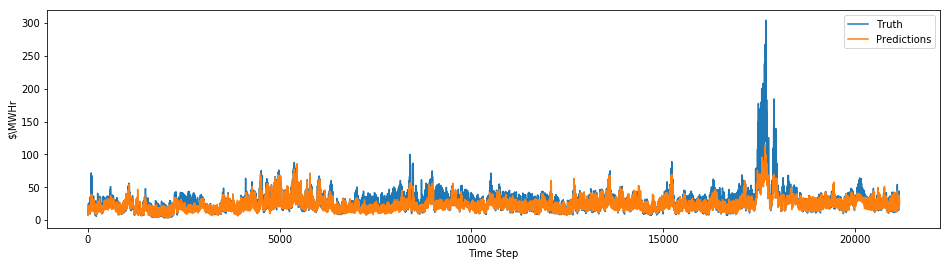

In [37]:
ax = train_df.plot(figsize=(16, 4))
ax.set_ylabel('$\MWHr')
ax.set_xlabel('Time Step')
plt.savefig('results/peoh-rf-train.pdf')
plt.savefig('results/peoh-rf-train.svg')

In [38]:
test_preds = get_predictions(X_test)

100%|██████████| 767/767 [00:01<00:00, 628.72it/s]


In [39]:
test_df = pd.DataFrame([y_test, test_preds], index=['Truth', 'Predictions']).T
test_df.head()

,Truth,Predictions
0,25.84154,28.629379
1,22.78535,28.156695
2,20.74440,17.096035
3,20.22108,17.415053
4,20.54554,18.077642


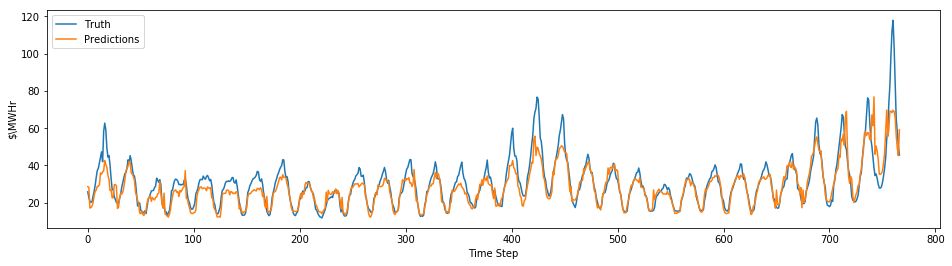

In [40]:
ax = test_df.plot(figsize=(16, 4))
ax.set_ylabel('$\MWHr')
ax.set_xlabel('Time Step')
plt.savefig('results/peoh-rf-test.pdf')
plt.savefig('results/peoh-rf-test.svg')

In [41]:
test_err = np.mean((test_df['Truth'] - test_df['Predictions'])**2)
test_err

39.57001469433163

# Results

In [42]:
results = pd.Series([train_err, test_err], index=['Train', 'Test'])
results

Train    102.185984
Test      39.570015
dtype: float64

In [43]:
results.to_csv('results/peoh-rf-mse.csv')